# 3D ResNet50 (all 1000 classes)

In [1]:
#%%python3 -m pip install --upgrade pip

In [2]:
%pip install mediapipe=='0.10.9'
%pip install opencv-python=='4.8.0.76'

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import sys
sys.path.append("..")
from train_utils import VideoDataset, validate_model, train_model, display_frames, validate_model_batched
from models_resnet import resnet50

2024-02-25 20:33:18.773755: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 20:33:22.360183: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import json

In [6]:
def save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic):
    with open(f'{save_path}/{model_name}_loss_acc_dynamic.json', 'w') as f:
        json.dump(
            {
                'train_loss_dynamic': train_loss_dynamic,
                'val_accuracy_dynamic': val_accuracy_dynamic
            },
            f)

In [7]:
use_cuda = True
seed = 1

train_batch_size = 1
test_batch_size = 1
val_batch_size = 1
IMG_SIZE = 112

limit_list = [] #["динозавр", "пингвин", "кролик"]

min_frame_count = 25

save = True

annotations_file = "/home/jupyter/mnt/s3/rsl-videos/slovo/slovo_annotations/SLOVO_DATAFRAME.tsv" # "/content/drive/MyDrive/slovo/SLOVO_DF_SHORT.tsv" #
dataloader_dir =  "/home/jupyter/mnt/s3/rsl-videos/slovo/" #"/content/drive/MyDrive/slovo/dataloaders/"

train_dataloader_name = 'color_frames_train_dataloader.pth'
val_dataloader_name = 'color_frames_val_dataloader.pth'

save_path = "/home/jupyter/mnt/s3/rsl-videos/slovo/models/all/resnet50" #'/content/drive/MyDrive/slovo/models/ResNet50' #'/content/model'

In [8]:
video_labels = pd.read_csv(annotations_file, sep='\t')
video_labels['group_rank'] = video_labels.groupby(['text']).cumcount()+1;
video_labels['dataset'] = np.where(video_labels['group_rank']<17,'train', np.where(video_labels['group_rank']<19,'val', 'test'))
if len(limit_list)>0:
  video_labels = video_labels[video_labels.text.isin(limit_list)]
video_labels.tail(5)

,attachment_id,text,user_id,height,width,length,begin,end,group_rank,dataset
19995,81cab3c3-80be-4eb1-b3bf-fd1b69034a16,отложенный,4d26ad833542291c50de9ce88fb4f64a,640,360,131.0,12,73,20,test
19996,4eeeea02-df4c-4667-872e-8387ed31c32e,башенные часы,3018b64d2c938f5b6a0826dfdf486f2c,640,360,145.0,17,83,20,test
19997,d947ab2e-0b6e-4ea7-a5dd-b401c572d177,дважды,3018b64d2c938f5b6a0826dfdf486f2c,640,360,127.0,13,63,20,test
19998,03edb6f1-1c91-46ce-8394-b74bca3b3cd7,время от 0 ночи до 12 дня,472fb939766ece63eb06e2d0e10eb679,840,358,178.0,16,138,19,test
19999,5393ec0c-85a4-4980-a2da-e84259050d83,время от 0 ночи до 12 дня,30eae85220a3d47b79b9955a08d31d63,640,360,205.0,32,172,20,test


In [9]:
classes = tuple(video_labels.text.unique())
n_class = len(classes)
print(f"Total number of classes: {n_class}. Example classes: {classes[:5]}")

Total number of classes: 1000. Example classes: ('Ё', 'А', 'Р', 'Е', 'Ч')


In [10]:
train_dataloader = torch.load(dataloader_dir + train_dataloader_name)
print(f"Train dataloader contains: {len(train_dataloader)} videos")
val_dataloader = torch.load(dataloader_dir + val_dataloader_name)
print(f"Val dataloader contains: {len(val_dataloader)} videos")

Train dataloader contains: 16000 videos
Val dataloader contains: 2000 videos


In [11]:
use_cuda = use_cuda and torch.cuda.is_available()

if use_cuda:
  for dl in [train_dataloader, val_dataloader]:
    dl.num_workers = 0
    dl.pin_memory = True
  torch.cuda.manual_seed(seed)  # Set the random seed for the current GPU
else:
  torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

print(f"Device: {device}")

Device: cuda


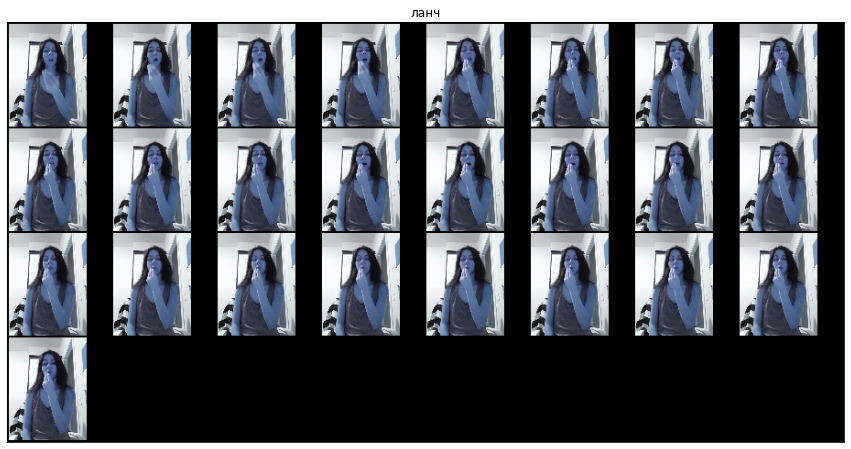

In [12]:
display_frames(n_frames=1, dataloader=train_dataloader, classes=classes)

In [13]:
frames, labels = next(iter(val_dataloader))
print(f"Frames shape: {frames.shape}") # (batch_size, -channels, frames, w, h) torch.Size([1, 3, 25, 112, 112])
print(f"Labels shape: {labels.shape}") # batch_size
print(f"Labels: {labels}") # class index

Frames shape: torch.Size([1, 3, 25, 112, 112])
Labels shape: torch.Size([1])
Labels: tensor([984])


# Update batch_size to 16

In [35]:
bs = 16
val_dataloader = DataLoader(val_dataloader.dataset, batch_size=bs, shuffle=False, sampler=None)
train_dataloader = DataLoader(train_dataloader.dataset, batch_size=bs, shuffle=True, sampler=None)
print(val_dataloader.batch_size, train_dataloader.batch_size)

16 16


# ResNet 50, $lr = 10^{-2}$ bs=16

In [36]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [37]:
lr_power = -2
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_all_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=9.6744; val acc=0.001
Train Epoch 2/30: train_loss=8.4228; val acc=0.001
Train Epoch 3/30: train_loss=14.5173; val acc=0.002
Train Epoch 4/30: train_loss=8.2774; val acc=0.001
Train Epoch 5/30: train_loss=8.1079; val acc=0.001
Train Epoch 6/30: train_loss=8.2958; val acc=0.001
Train Epoch 7/30: train_loss=8.4095; val acc=0.001
Train Epoch 8/30: train_loss=8.3946; val acc=0.002
Train Epoch 9/30: train_loss=8.2721; val acc=0.001
Train Epoch 10/30: train_loss=8.1665; val acc=0.001
Train Epoch 11/30: train_loss=8.0666; val acc=0.001
Train Epoch 12/30: train_loss=7.9024; val acc=0.001
Train Epoch 13/30: train_loss=7.7079; val acc=0.002
Train Epoch 14/30: train_loss=7.5177; val acc=0.001
Train Epoch 15/30: train_loss=7.2005; val acc=0.004
Train Epoch 16/30: train_loss=6.7232; val acc=0.005
Train Epoch 17/30: train_loss=6.2176; val acc=0.008
Train Epoch 18/30: train_loss=5.7508; val acc=0.011
Train Epoch 19/30: train_loss=5.2673; val acc=0.018
Train Epoch 20/30: t

# ResNet 50, $lr = 10^{-3}$ bs=16

In [15]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [16]:
lr_power = -3
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_all_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [17]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=7.2285; val acc=0.001
Train Epoch 2/30: train_loss=6.9358; val acc=0.001
Train Epoch 3/30: train_loss=6.8702; val acc=0.002
Train Epoch 4/30: train_loss=6.7587; val acc=0.003
Train Epoch 5/30: train_loss=6.4851; val acc=0.004
Train Epoch 6/30: train_loss=5.8834; val acc=0.009
Train Epoch 7/30: train_loss=5.0486; val acc=0.034
Train Epoch 8/30: train_loss=4.3242; val acc=0.047
Train Epoch 9/30: train_loss=3.711; val acc=0.067
Train Epoch 10/30: train_loss=3.1731; val acc=0.067
Train Epoch 11/30: train_loss=2.725; val acc=0.094
Train Epoch 12/30: train_loss=2.3163; val acc=0.112
Train Epoch 13/30: train_loss=1.8776; val acc=0.117
Train Epoch 14/30: train_loss=1.4911; val acc=0.100
Train Epoch 15/30: train_loss=1.1325; val acc=0.115
Train Epoch 16/30: train_loss=0.8164; val acc=0.134
Train Epoch 17/30: train_loss=0.5677; val acc=0.136
Train Epoch 18/30: train_loss=0.4123; val acc=0.116
Train Epoch 19/30: train_loss=0.2669; val acc=0.120
Train Epoch 20/30: trai

# ResNet 50,  𝑙𝑟=10−4  bs=16

In [18]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [19]:
lr_power = -4
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_all_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=7.1098; val acc=0.002
Train Epoch 2/30: train_loss=6.8563; val acc=0.002
Train Epoch 3/30: train_loss=6.6512; val acc=0.003
Train Epoch 4/30: train_loss=6.2619; val acc=0.006
Train Epoch 5/30: train_loss=5.5511; val acc=0.011
Train Epoch 6/30: train_loss=4.591; val acc=0.024
Train Epoch 7/30: train_loss=3.6434; val acc=0.041
Train Epoch 8/30: train_loss=2.8124; val acc=0.055
Train Epoch 9/30: train_loss=2.1879; val acc=0.076
Train Epoch 10/30: train_loss=1.6109; val acc=0.094
Train Epoch 11/30: train_loss=1.1391; val acc=0.086
Train Epoch 12/30: train_loss=0.7636; val acc=0.087
Train Epoch 13/30: train_loss=0.5152; val acc=0.082
Train Epoch 14/30: train_loss=0.3472; val acc=0.093
Train Epoch 15/30: train_loss=0.2466; val acc=0.097
Train Epoch 16/30: train_loss=0.178; val acc=0.105
Train Epoch 17/30: train_loss=0.1233; val acc=0.098
Train Epoch 18/30: train_loss=0.0898; val acc=0.115
Train Epoch 19/30: train_loss=0.06; val acc=0.112
Train Epoch 20/30: train_

# ResNet 50,  𝑙𝑟=10−5  bs=16

In [ ]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

In [ ]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_all_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

# Update batch_size to 1

In [ ]:
bs = 1
val_dataloader = DataLoader(val_dataloader.dataset, batch_size=bs, shuffle=False, sampler=None)
train_dataloader = DataLoader(train_dataloader.dataset, batch_size=bs, shuffle=True, sampler=None)
print(val_dataloader.batch_size, train_dataloader.batch_size)

# ResNet 50, $lr = 10^{-3}$ bs=1

In [ ]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

In [ ]:
lr_power = -3
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_all_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

# ResNet 50, $lr = 10^{-4}$ bs=1

In [ ]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

In [ ]:
lr_power = -4
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_all_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

# ResNet 50, $lr = 10^{-5}$ bs=1

In [ ]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

In [ ]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_all_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)